In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
os.path.dirname(sys.executable)
sys.path.append('/kuacc/users/baristopal20/SSuperGAN/')

In [3]:
from data.datasets.random_dataset import RandomDataset
from data.datasets.golden_panels import GoldenPanelsDataset
from data.augment import get_PIL_image

from networks.plain_ssupervae import PlainSSuperVAE
from training.vae_trainer import VAETrainer
from utils.config_utils import read_config, Config
from utils.logging_utils import *
from utils.plot_utils import *
from utils import pytorch_util as ptu

from configs.base_config import *
from functional.losses.elbo import elbo

In [73]:
config = read_config(Config.PLAIN_SSUPERVAE)
golden_age_config = read_config(Config.GOLDEN_AGE)

In [12]:
net = PlainSSuperVAE(config.backbone, 
                     latent_dim=config.latent_dim, 
                     embed_dim=config.embed_dim,
                     seq_size=config.seq_size,
                     decoder_channels=config.decoder_channels,
                     gen_img_size=config.image_dim).to(ptu.device) 

net.load_state_dict(torch.load("weights/model-18.pth")['model_state_dict'])
net.cuda()
net.eval()

Loaded pretrained weights for efficientnet-b5


PlainSSuperVAE(
  (encoder): PlainSequentialEncoder(
    (embedder): CNNEmbedder(
      (model): EfficientNet(
        (_conv_stem): Conv2dStaticSamePadding(
          3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
          (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
        )
        (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_blocks): ModuleList(
          (0): MBConvBlock(
            (_depthwise_conv): Conv2dStaticSamePadding(
              48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
              (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
            )
            (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
            (_se_reduce): Conv2dStaticSamePadding(
              48, 12, kernel_size=(1, 1), stride=(1, 1)
              (static_padding): Identity()
            )
            (_se_expa

In [75]:
dataset = GoldenPanelsDataset(golden_age_config.panel_path,
                              golden_age_config.sequence_path, 
                              golden_age_config.panel_dim,
                              config.image_dim, 
                              augment=False, 
                              mask_val=1, # mask with white color for 1 and black color for 0
                              mask_all=False, # masks faces from all panels and returns all faces
                              return_mask=True,
                              train_test_ratio=golden_age_config.train_test_ratio,
                              train_mode=False,
                              limit_size=-1)

data_loader = DataLoader(dataset, batch_size=1)

In [61]:
dl_iter = iter(data_loader)

In [78]:
x, y, z = next(dl_iter)

torch.Size([1, 300, 300])


## Masking Test

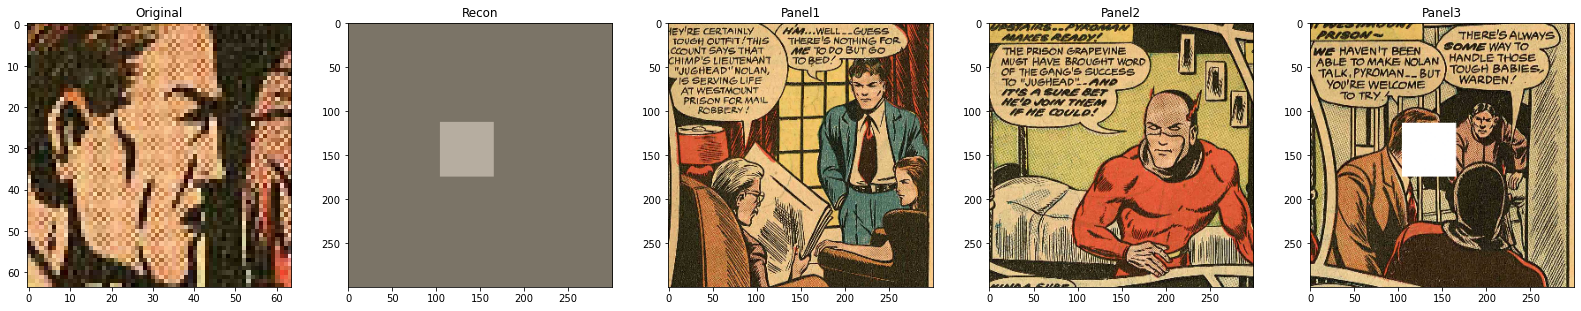

In [79]:
plot_panels_and_faces(x, y, z.unsqueeze(0).repeat(1, 3, 1, 1))

## Model Result Test

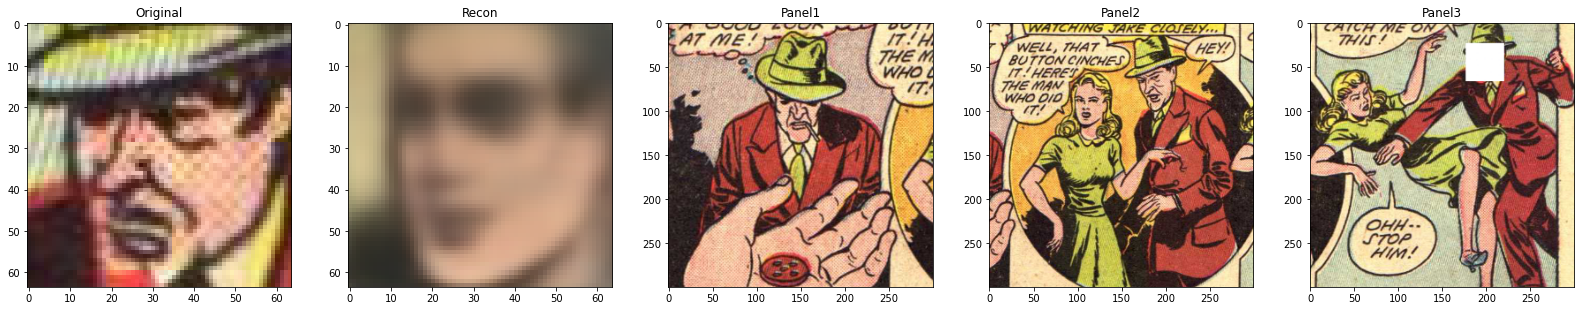

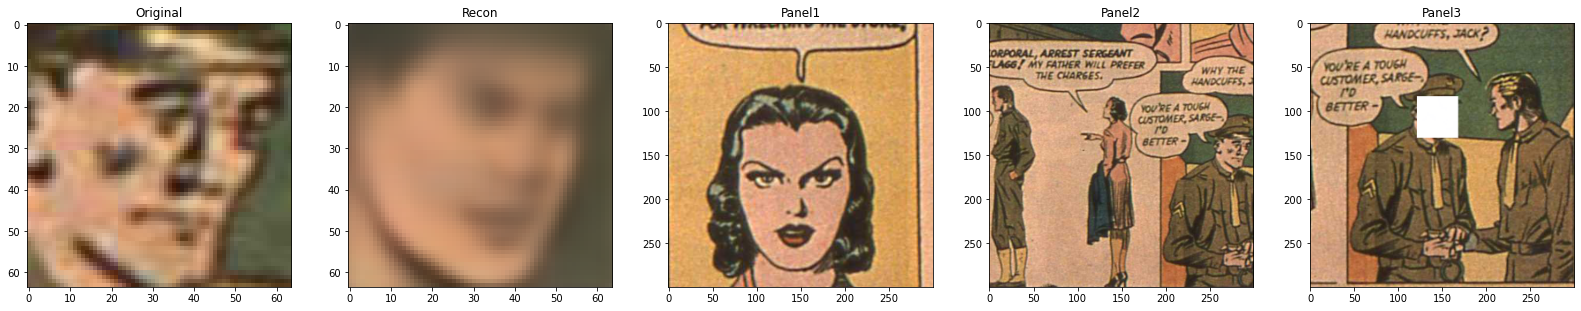

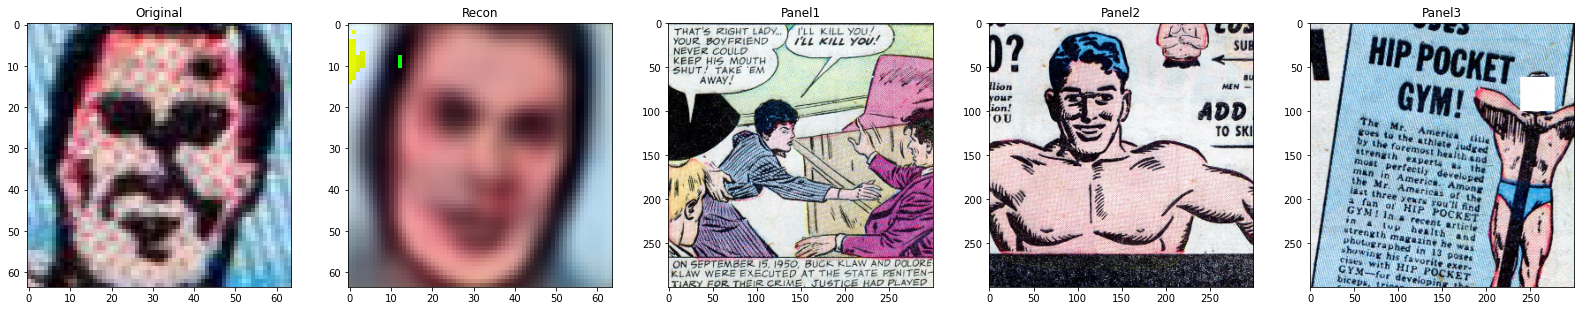

In [85]:
ctr, limit = 0, 3

for _ in range(limit):
    x, y, z = next(dl_iter)
    
    with torch.no_grad():
        _, _, _, y_recon, _ = net(x.cuda())   
    plot_panels_and_faces(x, y, y_recon)